## 0. Thiết lập môi trường & thư viện

Phần này chuẩn bị môi trường chạy cho toàn bộ pipeline:

- Import các thư viện xử lý dữ liệu và trực quan hóa  
- Cài đặt và tải dữ liệu NLTK phục vụ tiền xử lý văn bản (stopwords, tokenize, wordnet)  
- Cài đặt `transformers` để sử dụng mô hình BERT  
- Kiểm tra GPU và chọn thiết bị chạy phù hợp (CUDA nếu có)

**Kết quả mong đợi:** notebook sẵn sàng chạy các bước tiền xử lý, huấn luyện và suy luận với BERT.


In [2]:

import re
import statistics as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

!pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.optim import AdamW

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

# Define device
device = 'cuda' if len(tf.config.experimental.list_physical_devices('GPU')) > 0 else 'cpu'
print(f"Using device: {device}")

Num GPUs Available:  1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using device: cuda


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
gpus = tf.config.list_physical_devices('GPU')
print("GPUs:", gpus)

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

2.19.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## 1. Tải và khám phá tập dữ liệu

Phần này sử dụng `kagglehub` để tải trực tiếp bộ dữ liệu *Hate Speech and Offensive Language Dataset* từ Kaggle.

Sau khi tải xong, thư mục dữ liệu được liệt kê để:
- Xác nhận dữ liệu đã được tải thành công  
- Kiểm tra các file có trong bộ dữ liệu  
- Chuẩn bị cho bước đọc và tiền xử lý dữ liệu ở các phần tiếp theo

**Kết quả mong đợi:** đường dẫn tới thư mục dữ liệu và danh sách các file chứa trong đó.


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mrmorj/hate-speech-and-offensive-language-dataset")

print("Path to dataset files:", path)
print("Files in dataset directory:", os.listdir(path))

100%|██████████| 1.01M/1.01M [00:00<00:00, 35.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mrmorj/hate-speech-and-offensive-language-dataset/versions/1
Files in dataset directory: ['labeled_data.csv']


## 2. Đọc và kiểm tra cấu trúc dữ liệu

Dữ liệu được đọc từ file CSV đã tải về và lưu vào DataFrame của pandas.

Ở bước này, thực hiện:
- Hiển thị một vài dòng đầu tiên để quan sát nội dung văn bản và nhãn
- Kiểm tra thông tin tổng quát của tập dữ liệu, bao gồm số lượng mẫu, số cột và kiểu dữ liệu
- Xác định các cột liên quan đến nhãn (*hate speech*, *offensive language*, *neither*) và cột văn bản (*tweet*)

**Kết quả mong đợi:** nắm rõ cấu trúc dữ liệu trước khi tiến hành tiền xử lý và xây dựng mô hình.


In [7]:
from IPython.display import display
data = pd.read_csv(path + '/labeled_data.csv')
print("dataset head:")
display(data.head())
print("dataset info:")
data.info()


dataset head:


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


## 3. Làm sạch dữ liệu và chuẩn hóa nhãn

Ở bước này, tập dữ liệu được tinh gọn để chỉ giữ lại các thông tin cần thiết cho bài toán phân loại văn bản.

Các thao tác chính gồm:
- Loại bỏ các cột không dùng trực tiếp cho huấn luyện mô hình  
- Đổi tên cột nhãn về dạng thống nhất (`label`)  
- Ánh xạ nhãn số sang nhãn dạng chuỗi để dễ phân tích và diễn giải  
- Kiểm tra lại dữ liệu sau khi làm sạch và phân bố các lớp

**Kết quả mong đợi:** tập dữ liệu gọn nhẹ, rõ ràng, sẵn sàng cho bước tiền xử lý văn bản và huấn luyện mô hình.


In [8]:
data_cleaned = data.drop(columns = ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither'])
data_cleaned.rename(columns = {'class':'label'}, inplace=True)

label_mapping = {0: 'hate_speech', 1: 'offensive_language', 2: 'neither'}
data_cleaned['label'] = data_cleaned['label'].map(label_mapping)

print("Cleaned dataset head:")
print(data_cleaned.head())
print("Cleaned dataset info:")
data_cleaned.info()
print("Value counts for labels:")
print(data_cleaned['label'].value_counts())

Cleaned dataset head:
                label                                              tweet
0             neither  !!! RT @mayasolovely: As a woman you shouldn't...
1  offensive_language  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2  offensive_language  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3  offensive_language  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4  offensive_language  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
Cleaned dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   24783 non-null  object
 1   tweet   24783 non-null  object
dtypes: object(2)
memory usage: 387.4+ KB
Value counts for labels:
label
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


## 4. Trực quan hóa phân bố nhãn

Biểu đồ cột được sử dụng để quan sát số lượng mẫu ở từng lớp nhãn trong tập dữ liệu.  
Bước này giúp đánh giá nhanh mức độ **cân bằng/không cân bằng** giữa các lớp, từ đó định hướng chiến lược huấn luyện và đánh giá mô hình.

**Kết quả mong đợi:** nhìn rõ lớp nào chiếm đa số và lớp nào ít hơn trong tập dữ liệu.


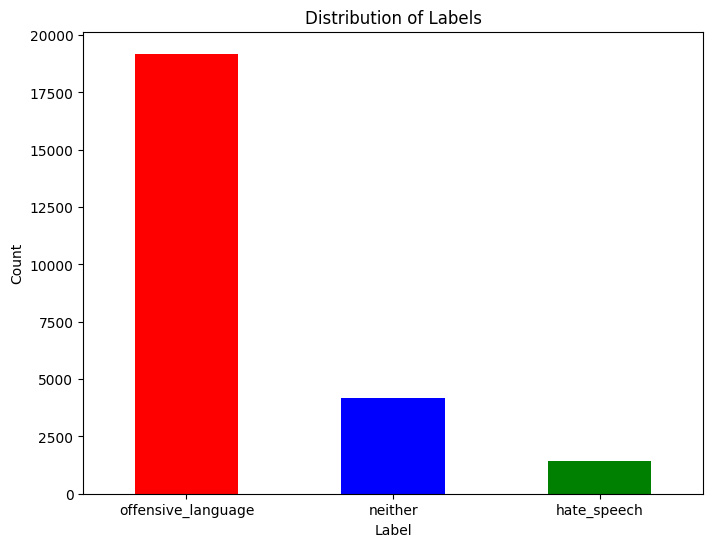

In [9]:
plt.figure(figsize=(8,6))
data_cleaned['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

## 5. Tiền xử lý văn bản (Text Preprocessing)

Dữ liệu tweet thường chứa nhiều thành phần gây nhiễu (URL, mention, hashtag, ký tự đặc biệt).  
Bước này chuẩn hóa văn bản để mô hình tập trung vào nội dung chính.

Các thao tác được áp dụng:
- Loại bỏ URL (link)  
- Loại bỏ mention (ví dụ: `@username`)  
- Loại bỏ hashtag (ví dụ: `#topic`)  
- Chuyển toàn bộ về chữ thường (lowercase)  
- Tokenize văn bản thành các từ  
- Lọc chỉ giữ token là chữ cái và loại bỏ stopwords tiếng Anh  
- Ghép token trở lại thành chuỗi để đưa vào pipeline huấn luyện

**Kết quả mong đợi:** cột `tweet` đã được làm sạch và đồng nhất định dạng trước khi đưa vào mô hình.


# 5.5. Chia tập Train/Test trước khi tăng cường dữ liệu

 Để tránh *data leakage*, tập dữ liệu được chia thành train và test **trước khi áp dụng data augmentation**.

 - Tập **train** sẽ được tăng cường dữ liệu và cân bằng nhãn  
 - Tập **test** được giữ nguyên từ dữ liệu gốc để đánh giá khách quan khả năng tổng quát hóa

 **Kết quả mong đợi:** tập test không bị ảnh hưởng bởi augmentation, giúp kết quả đánh giá đáng tin cậy.


In [10]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = text.lower()  # Lowercase
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stopwords]  # Remove stopwords and non-alphabetic tokens
    return ' '.join(filtered_tokens)
data_cleaned['tweet'] = data_cleaned['tweet'].apply(clean_text)

print('Data after cleaning:')
print(data_cleaned.head())



# 1) tách ra test 10% trước
trainval_df, test_df = train_test_split(
    data_cleaned,
    test_size=0.10,
    random_state=42,
    stratify=data_cleaned['label']
)

# 2) từ phần còn lại tách tiếp val 10% tổng (tức 10/90 của trainval)
val_size = 0.10 / 0.90  # = 0.111111...
train_df, val_df = train_test_split(
    trainval_df,
    test_size=val_size,
    random_state=42,
    stratify=trainval_df['label']
)

print("Train size:", len(train_df))
print("Val size  :", len(val_df))
print("Test size :", len(test_df))

print("\nTrain label distribution:\n", train_df['label'].value_counts())
print("\nVal label distribution:\n", val_df['label'].value_counts())
print("\nTest label distribution:\n", test_df['label'].value_counts())

Data after cleaning:
                label                                              tweet
0             neither  rt woman complain cleaning house amp man alway...
1  offensive_language  rt boy dats cold tyga dwn bad cuffin dat hoe p...
2  offensive_language  rt dawg rt ever fuck bitch start cry confused ...
3  offensive_language                                rt look like tranny
4  offensive_language  rt shit hear might true might faker bitch told ya
Train size: 19825
Val size  : 2479
Test size : 2479

Train label distribution:
 label
offensive_language    15350
neither                3331
hate_speech            1144
Name: count, dtype: int64

Val label distribution:
 label
offensive_language    1920
neither                416
hate_speech            143
Name: count, dtype: int64

Test label distribution:
 label
offensive_language    1920
neither                416
hate_speech            143
Name: count, dtype: int64



## 6. Tăng cường dữ liệu (Data Augmentation) trên tập huấn luyện

 Một số lớp (đặc biệt là *hate_speech*) có thể ít mẫu hơn, gây mất cân bằng nhãn.
 Để cải thiện khả năng học của mô hình với lớp thiểu số, áp dụng augmentation bằng **synonym replacement**
 dựa trên WordNet **chỉ trên tập train**.

 Quy trình:
 - Lọc các tweet thuộc lớp `hate_speech` trong tập train
 - Tạo thêm nhiều biến thể bằng cách thay thế ngẫu nhiên một từ bằng từ đồng nghĩa
 - Ghép các mẫu tăng cường vào **train_df** để tạo **train_augmented**

 **Kết quả mong đợi:** số lượng mẫu lớp `hate_speech` trong train tăng lên, trong khi test vẫn giữ nguyên.


BEFORE augmentation:
label
offensive_language    15350
neither                3331
hate_speech            1144
Name: count, dtype: int64
hate_speech_train size: 1144
augment_df size: 3420

AFTER augmentation:
label
offensive_language    15350
hate_speech            4564
neither                3331
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels After Augmentation')

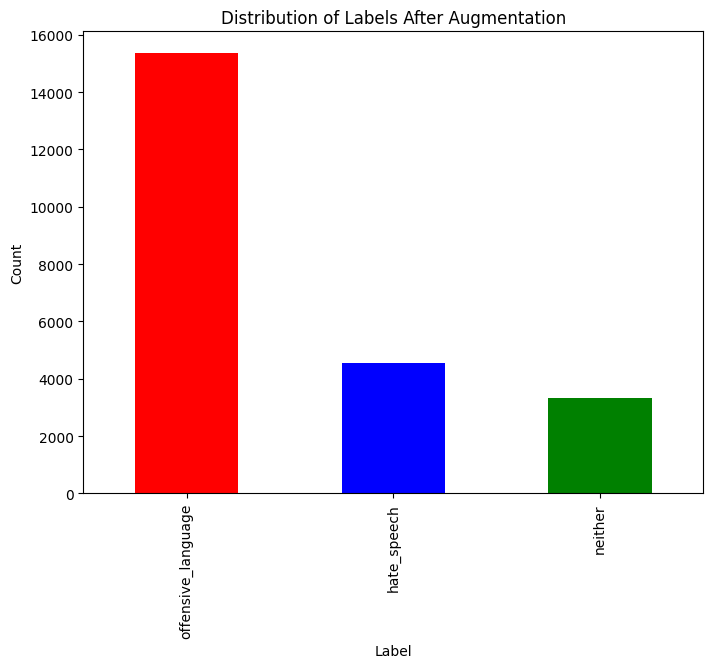

In [11]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ").lower()
            if synonym != word:
                synonyms.add(synonym)
    return list(synonyms)

def augment_text(text, num_augments=1):
    word = text.split()
    augment_text = []

    for i in range(num_augments):
        new_words = list(word)

        if not new_words:
            continue

        random_word_index = np.random.randint(0, len(new_words))
        random_word = new_words[random_word_index]

        synonyms = get_synonyms(random_word)
        if synonyms:
            random_synonym = np.random.choice(synonyms)
            new_words[random_word_index] = random_synonym

        augment_text.append(' '.join(new_words))
    return augment_text

hate_speech_train = train_df[train_df['label'] == 'hate_speech'].copy()

augment_samples = []
for _, row in hate_speech_train.iterrows():
    augmented_texts = augment_text(row['tweet'], num_augments=3)
    for aug_text in augmented_texts:
        augment_samples.append({
            'tweet': aug_text,
            'label': 'hate_speech'
        })

augment_df = pd.DataFrame(augment_samples)

train_augmented = pd.concat([train_df, augment_df], ignore_index=True)

print("BEFORE augmentation:")
print(train_df['label'].value_counts())

print("hate_speech_train size:", len(hate_speech_train))
print("augment_df size:", len(augment_df))

print("\nAFTER augmentation:")
print(train_augmented['label'].value_counts())

plt.figure(figsize=(8,6))
train_augmented['label'].value_counts().plot(kind='bar', color = ['red', 'blue', 'green'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Augmentation')


## 7. Cân bằng dữ liệu trên tập huấn luyện

 Sau augmentation, tiếp tục cân bằng số lượng mẫu giữa các lớp **chỉ trong tập train** để giảm thiên lệch về lớp đa số.
 Tập test không thay đổi và được dùng để đánh giá khách quan.

 Chiến lược:
 - Xác định `target_count` là số mẫu lớn nhất trong các lớp của tập train
 - Với lớp dư mẫu: downsample về `target_count`
 - Với lớp thiếu mẫu: oversample và tạo thêm câu mới bằng synonym replacement để bù phần thiếu
 - Shuffle lại để tránh bias theo thứ tự dữ liệu

 **Kết quả mong đợi:** `train_balanced` có phân bố nhãn cân bằng, sẵn sàng cho bước huấn luyện.


Target count for balancing: 15350

Final class distribution:
label
neither               15350
hate_speech           15350
offensive_language    15350
Name: count, dtype: int64


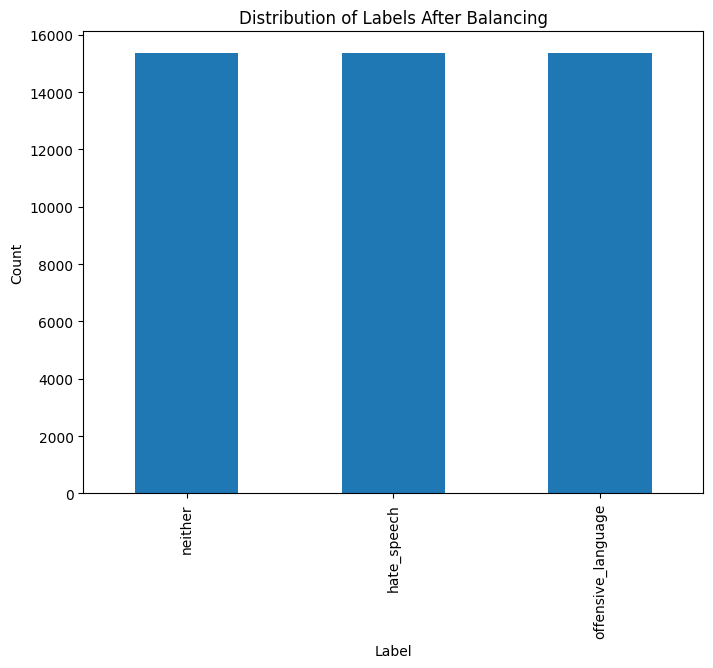

Total samples: 46050
                label                                              tweet
0             neither                                oreo ice cream cake
1         hate_speech  ok u fat precious lookin ass bitch u big produ...
2         hate_speech                     atomic number 20 put up faggot
3  offensive_language  cigarette break nd wtf mt eyes glowing like ch...
4             neither                                           folderol


In [12]:
# 1) Tách theo label dạng chuỗi
df_hate = train_augmented[train_augmented['label'] == 'hate_speech']
df_off  = train_augmented[train_augmented['label'] == 'offensive_language']
df_nei  = train_augmented[train_augmented['label'] == 'neither']

# 2) Target = lớp nhiều nhất
target_count = max(len(df_hate), len(df_off), len(df_nei))
print("Target count for balancing:", target_count)

def augment_to_target(df_class, target):
    # Nếu đã >= target thì downsample về đúng target
    if len(df_class) >= target:
        return df_class.sample(n=target, replace=False, random_state=42)

    # Nếu thiếu thì oversample + augment
    need = target - len(df_class)
    seeds = df_class.sample(n=need, replace=True, random_state=42)

    augmented_rows = []
    for _, row in seeds.iterrows():
        # tạo 1 câu mới
        new_text = augment_text(row['tweet'], num_augments=1)
        new_text = new_text[0] if new_text else row['tweet']  # phòng trường hợp rỗng

        augmented_rows.append({
            'tweet': new_text,
            'label': row['label']
        })

    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df_class, augmented_df], ignore_index=True)

balanced_hate = augment_to_target(df_hate, target_count)
balanced_nei  = augment_to_target(df_nei, target_count)

# 3) Ghép lại dataset cân bằng (giữ offensive nguyên)
train_balanced = pd.concat(
    [df_off, balanced_hate, balanced_nei],
    ignore_index=True
)

# 4) Shuffle
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nFinal class distribution:")
print(train_balanced['label'].value_counts())

plt.figure(figsize=(8,6))
train_balanced['label'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Balancing')
plt.show()

print("Total samples:", len(train_balanced))
print(train_balanced.head())


## 8. Chuẩn bị dữ liệu đầu vào cho BERT

Sau khi cân bằng dữ liệu trên tập train, tạo các tập dữ liệu cuối cùng:
- `X_train`, `y_train` lấy từ `train_balanced`
- `X_test`, `y_test` lấy từ `test_df` (giữ nguyên dữ liệu gốc)

Đồng thời:
- Mã hóa nhãn từ dạng chuỗi sang chỉ số lớp (0–2) và one-hot (3 lớp)
- Thiết lập `max_seq_length` để chuẩn hóa độ dài chuỗi đầu vào cho BERT

**Kết quả mong đợi:** dữ liệu train/test sẵn sàng cho tokenization và huấn luyện mô hình.


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

X_train = train_balanced['tweet'].values
y_train = train_balanced['label'].values

X_val  = val_df['tweet'].values
y_val  = val_df['label'].values

X_test = test_df['tweet'].values
y_test = test_df['label'].values


y_train_encoded = to_categorical([{'hate_speech':0, 'offensive_language':1, 'neither':2}[label] for label in y_train], num_classes=3)
y_test_encoded = to_categorical([{'hate_speech':0, 'offensive_language':1, 'neither':2}[label] for label in y_test], num_classes=3)
max_seq_length = 128
print("The y train_encoded head: ")
print(y_train_encoded[:5])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The y train_encoded head: 
[[0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


## 9. Kiểm tra kết quả tokenization (sanity check)

Trước khi huấn luyện, thực hiện một kiểm tra nhanh để đảm bảo pipeline BERT tokenization hoạt động đúng.

Ở bước này:
- Chọn một mẫu văn bản từ tập train
- Tokenize với BERT và giới hạn độ dài để dễ quan sát
- In ra:
  - Danh sách token sau khi tokenize (bao gồm `[CLS]`, `[SEP]`, `[PAD]`)
  - `input_ids` tương ứng với từng token
  - `attention_mask` để phân biệt token thật và token padding
- Trích xuất các token có `mask = 1` để xem phần nội dung thực sự được mô hình “nhìn thấy”

**Kết quả mong đợi:** tokenization hợp lý, mask đúng, không bị lỗi padding/truncation ngoài ý muốn.


In [14]:
text = X_train[0]
print("RAW TEXT:\n", text)

enc = tokenizer(
    text,
    add_special_tokens=True,
    truncation=True,
    padding="max_length",
    max_length=32,
    return_attention_mask=True,
    return_tensors="tf"
)

input_ids = enc["input_ids"][0].numpy()
attn_mask = enc["attention_mask"][0].numpy()
tokens = tokenizer.convert_ids_to_tokens(input_ids)

print("\nTOKENS:")
print(tokens)

print("\nINPUT_IDS:")
print(input_ids)

print("\nATTENTION_MASK:")
print(attn_mask)

real_tokens = [tok for tok, m in zip(tokens, attn_mask) if m == 1]
print("\nREAL TOKENS (mask=1):")
print(real_tokens)


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


RAW TEXT:
 oreo ice cream cake

TOKENS:
['[CLS]', 'ore', '##o', 'ice', 'cream', 'cake', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

INPUT_IDS:
[  101 10848  2080  3256  6949  9850   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]

ATTENTION_MASK:
[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

REAL TOKENS (mask=1):
['[CLS]', 'ore', '##o', 'ice', 'cream', 'cake', '[SEP]']


## 10. Khởi tạo mô hình BERT cho bài toán phân loại

Mô hình `BertForSequenceClassification` được sử dụng để giải bài toán phân loại văn bản với nhiều nhãn.

Thiết lập bao gồm:
- Tải trọng số pre-trained từ `bert-base-uncased`
- Cấu hình số lượng nhãn đầu ra phù hợp với bài toán (3 lớp)
- Khởi tạo optimizer AdamW với learning rate nhỏ để fine-tune BERT ổn định

**Kết quả mong đợi:** mô hình BERT và optimizer được khởi tạo thành công, sẵn sàng cho quá trình huấn luyện và đánh giá.


In [15]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

optimizer = AdamW(model.parameters(), lr=2e-5)

print("Bert Pytorch model loaded successfully.")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bert Pytorch model loaded successfully.


## 11. Chuẩn bị dữ liệu huấn luyện cho PyTorch (TensorDataset & DataLoader)

Để huấn luyện BERT với PyTorch, dữ liệu cần được chuyển về dạng tensor và đóng gói theo chuẩn `DataLoader`.

Các bước thực hiện:
- Tạo ánh xạ nhãn từ dạng chuỗi sang số (`label2id`) để phù hợp với mô hình phân loại
- Chuyển toàn bộ nhãn của tập train/test sang `label_ids` (kiểu `int64`)
- Tokenize dữ liệu theo batch và trả về các tensor:
  - `input_ids`
  - `attention_masks`
  - `labels`
- Đóng gói tensor thành `TensorDataset`
- Tạo `DataLoader`:
  - Train dùng `RandomSampler` để trộn dữ liệu theo batch
  - Validation dùng `SequentialSampler` để duyệt tuần tự
- In ra kích thước một batch để kiểm tra nhanh định dạng đầu vào

**Kết quả mong đợi:** `train_dataloader` và `val_dataloader` được tạo thành công và có shape đúng chuẩn cho fine-tuning BERT.


In [16]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

label2id = {'hate_speech': 0, 'offensive_language': 1, 'neither': 2}

def to_label_ids(labels):
    labels = np.asarray(labels)
    if labels.dtype == object or isinstance(labels[0], str):
        labels = np.array([label2id[x] for x in labels], dtype=np.int64)
    else:
        labels = labels.astype(np.int64)
    return labels

y_train_ids = to_label_ids(y_train)
y_val_ids   = to_label_ids(y_val)
y_test_ids  = to_label_ids(y_test)

def prepare_data(texts, labels_ids, tokenizer, max_length=128):
    enc = tokenizer(
        list(texts),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = enc['input_ids']
    attention_masks = enc['attention_mask']
    labels_tensor = torch.tensor(labels_ids, dtype=torch.long)
    return input_ids, attention_masks, labels_tensor

train_input_ids, train_attention_masks, train_labels = prepare_data(X_train, y_train_ids, tokenizer, 128)
val_input_ids,   val_attention_masks,   val_labels   = prepare_data(X_val,   y_val_ids,   tokenizer, 128)
test_input_ids,  test_attention_masks,  test_labels  = prepare_data(X_test,  y_test_ids,  tokenizer, 128)

train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset   = TensorDataset(val_input_ids,   val_attention_masks,   val_labels)
test_dataset  = TensorDataset(test_input_ids,  test_attention_masks,  test_labels)

batch_size = 32
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader   = DataLoader(val_dataset,   sampler=SequentialSampler(val_dataset), batch_size=batch_size)
test_dataloader  = DataLoader(test_dataset,  sampler=SequentialSampler(test_dataset), batch_size=batch_size)

print("Train batch shapes:",
      next(iter(train_dataloader))[0].shape,
      next(iter(train_dataloader))[1].shape,
      next(iter(train_dataloader))[2].shape)


Train batch shapes: torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32])


In [17]:
from google.colab import files

## 12. Huấn luyện mô hình (Fine-tuning) với Early Stopping và lưu checkpoint tốt nhất

Phần này thực hiện quá trình fine-tune BERT trên tập dữ liệu đã chuẩn bị, đồng thời theo dõi chất lượng trên tập validation để tránh overfitting.

Các điểm chính trong quy trình huấn luyện:
- Thiết lập thư mục lưu kết quả (`checkpoints/`) và đường dẫn lưu mô hình tốt nhất
- Tự động chọn thiết bị chạy (GPU nếu có, ngược lại dùng CPU)
- Cấu hình siêu tham số huấn luyện: số epoch, batch size, learning rate và `patience` cho early stopping
- Sử dụng `AdamW` và learning rate scheduler tuyến tính để tối ưu ổn định khi fine-tune
- Vòng lặp huấn luyện theo epoch gồm:
  - `train()`: lan truyền xuôi/ngược, gradient clipping, optimizer step và scheduler step
  - `eval()`: tính validation loss và accuracy
- Lưu mô hình tốt nhất khi validation loss cải thiện theo 2 định dạng:
  - **HuggingFace folder** (`checkpoints/bert_best/`): thuận tiện load lại bằng `from_pretrained`
  - **state_dict** (`checkpoints/best_model.pt`): dạng nhẹ, linh hoạt khi tự load bằng PyTorch
- Kích hoạt early stopping khi không còn cải thiện sau `patience` epoch liên tiếp

Tùy môi trường chạy (Colab), có thể nén và lưu toàn bộ thư mục `checkpoints/` lên Google Drive để tránh mất dữ liệu sau khi runtime reset.

**Kết quả mong đợi:** mô hình tốt nhất được lưu trong `checkpoints/`, kèm theo log loss/accuracy theo từng epoch.


In [18]:
# =========================
# TRAIN + EARLY STOPPING + SAVE BEST MODEL
# Tweaks for better generalization:
# - lower LR + weight decay
# - warmup ratio
# - optional mixed precision
# - track macro-F1 (in addition to loss/acc)
# =========================

import os
import numpy as np
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
import shutil

print("Current working dir:", os.getcwd())

# --------- 0) Save paths ----------
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

BEST_PT_PATH = os.path.join(SAVE_DIR, "best_model.pt")
BEST_HF_DIR  = os.path.join(SAVE_DIR, "bert_best")
os.makedirs(BEST_HF_DIR, exist_ok=True)

# --------- 1) Device ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")

use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

# --------- 2) Training params ----------
epochs = 10            # giảm vì mô hình overfit sớm
patience = 3          # early stop nhanh hơn
best_val_loss = float("inf")
patience_counter = 0

lr = 2e-5             # giảm LR để ổn định hơn
weight_decay = 0.01   # regularization nhẹ
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

total_steps = len(train_dataloader) * epochs
warmup_steps = int(0.1 * total_steps)  # warmup 10%

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

train_losses, val_losses, val_accuracies, val_f1s = [], [], [], []

# --------- 3) Training loop ----------
for epoch_i in range(epochs):
    print(f"\n======== Epoch {epoch_i + 1} / {epochs} ========")

    # ---- Train ----
    model.train()
    total_train_loss = 0.0

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training", leave=False)):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
                labels=b_labels
            )
            loss = outputs.loss

        total_train_loss += loss.item()

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if step % 50 == 0 and step != 0:
            print(f"  Step {step}/{len(train_dataloader)} | avg loss so far: {total_train_loss/(step+1):.4f}")

    avg_train_loss = total_train_loss / max(1, len(train_dataloader))
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # ---- Validate ----
    model.eval()
    total_eval_loss = 0.0
    total_eval_accuracy = 0.0

    val_preds_all, val_labels_all = [], []

    for batch in tqdm(val_dataloader, desc="Validation", leave=False):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=use_amp):
                outputs = model(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask,
                    labels=b_labels
                )

        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        labels = b_labels.detach().cpu().numpy()

        val_preds_all.extend(preds)
        val_labels_all.extend(labels)

        batch_acc = (preds == labels).mean()
        total_eval_accuracy += batch_acc

    avg_val_loss = total_eval_loss / max(1, len(val_dataloader))
    avg_val_acc  = total_eval_accuracy / max(1, len(val_dataloader))
    avg_val_f1   = f1_score(val_labels_all, val_preds_all, average="macro")

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)
    val_f1s.append(avg_val_f1)

    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Acc : {avg_val_acc:.4f}")
    print(f"Validation F1  : {avg_val_f1:.4f}")

    # ---- Early stopping + Save best (by val loss) ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0

        model.save_pretrained(BEST_HF_DIR)
        tokenizer.save_pretrained(BEST_HF_DIR)

        torch.save(model.state_dict(), BEST_PT_PATH)

        print(f"✅ Improved! Saved to:\n - {BEST_HF_DIR}\n - {BEST_PT_PATH}")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("🛑 Early stopping triggered.")
            break

print("\nTraining complete!")
print("Best val loss:", best_val_loss)

# --------- 4) Zip & save to Drive (optional) ----------
try:
    zip_name = "checkpoints_final"  # will create checkpoints_final.zip
    drive_dest = "/content/drive/MyDrive/checkpoints_final.zip"

    print(f"\nĐang nén thư mục '{SAVE_DIR}'...")
    if os.path.exists(SAVE_DIR):
        shutil.make_archive(zip_name, 'zip', SAVE_DIR)

        print(f"Đang copy vào Drive: {drive_dest}")
        shutil.copy(f"{zip_name}.zip", drive_dest)

        print("✅ THÀNH CÔNG: File đã được lưu vào Google Drive.")
    else:
        print(f"❌ Không tìm thấy thư mục {SAVE_DIR} để nén.")
except Exception as e:
    print(f"❌ Lỗi khi lưu Drive: {e}")


Current working dir: /content
Using device: cuda

======== Epoch 1 / 10 ========


/tmp/ipython-input-2458193438.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


  Step 50/1440 | avg loss so far: 1.1289
  Step 100/1440 | avg loss so far: 1.1278
  Step 150/1440 | avg loss so far: 1.1220
  Step 200/1440 | avg loss so far: 1.1161
  Step 250/1440 | avg loss so far: 1.1086
  Step 300/1440 | avg loss so far: 1.0978
  Step 350/1440 | avg loss so far: 1.0809
  Step 400/1440 | avg loss so far: 1.0598
  Step 450/1440 | avg loss so far: 1.0392
  Step 500/1440 | avg loss so far: 1.0174
  Step 550/1440 | avg loss so far: 0.9938
  Step 600/1440 | avg loss so far: 0.9685
  Step 650/1440 | avg loss so far: 0.9445
  Step 700/1440 | avg loss so far: 0.9206
  Step 750/1440 | avg loss so far: 0.8999
  Step 800/1440 | avg loss so far: 0.8811
  Step 850/1440 | avg loss so far: 0.8632
  Step 900/1440 | avg loss so far: 0.8455
  Step 950/1440 | avg loss so far: 0.8291
  Step 1000/1440 | avg loss so far: 0.8146
  Step 1050/1440 | avg loss so far: 0.8025
  Step 1100/1440 | avg loss so far: 0.7896
  Step 1150/1440 | avg loss so far: 0.7778
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Validation Loss: 0.4592
Validation Acc : 0.8249
Validation F1  : 0.7090
✅ Improved! Saved to:
 - checkpoints/bert_best
 - checkpoints/best_model.pt

======== Epoch 2 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


  Step 50/1440 | avg loss so far: 0.4428
  Step 100/1440 | avg loss so far: 0.4328
  Step 150/1440 | avg loss so far: 0.4159
  Step 200/1440 | avg loss so far: 0.4126
  Step 250/1440 | avg loss so far: 0.4123
  Step 300/1440 | avg loss so far: 0.4098
  Step 350/1440 | avg loss so far: 0.4095
  Step 400/1440 | avg loss so far: 0.4054
  Step 450/1440 | avg loss so far: 0.4073
  Step 500/1440 | avg loss so far: 0.4062
  Step 550/1440 | avg loss so far: 0.4044
  Step 600/1440 | avg loss so far: 0.3997
  Step 650/1440 | avg loss so far: 0.3974
  Step 700/1440 | avg loss so far: 0.3932
  Step 750/1440 | avg loss so far: 0.3895
  Step 800/1440 | avg loss so far: 0.3857
  Step 850/1440 | avg loss so far: 0.3821
  Step 900/1440 | avg loss so far: 0.3794
  Step 950/1440 | avg loss so far: 0.3748
  Step 1000/1440 | avg loss so far: 0.3712
  Step 1050/1440 | avg loss so far: 0.3664
  Step 1100/1440 | avg loss so far: 0.3637
  Step 1150/1440 | avg loss so far: 0.3613
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Validation Loss: 0.5002
Validation Acc : 0.8100
Validation F1  : 0.6962
No improvement. Patience: 1/3

======== Epoch 3 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


  Step 50/1440 | avg loss so far: 0.2478
  Step 100/1440 | avg loss so far: 0.2611
  Step 150/1440 | avg loss so far: 0.2613
  Step 200/1440 | avg loss so far: 0.2685
  Step 250/1440 | avg loss so far: 0.2602
  Step 300/1440 | avg loss so far: 0.2643
  Step 350/1440 | avg loss so far: 0.2619
  Step 400/1440 | avg loss so far: 0.2642
  Step 450/1440 | avg loss so far: 0.2632
  Step 500/1440 | avg loss so far: 0.2599
  Step 550/1440 | avg loss so far: 0.2592
  Step 600/1440 | avg loss so far: 0.2563
  Step 650/1440 | avg loss so far: 0.2524
  Step 700/1440 | avg loss so far: 0.2490
  Step 750/1440 | avg loss so far: 0.2464
  Step 800/1440 | avg loss so far: 0.2470
  Step 850/1440 | avg loss so far: 0.2437
  Step 900/1440 | avg loss so far: 0.2425
  Step 950/1440 | avg loss so far: 0.2400
  Step 1000/1440 | avg loss so far: 0.2368
  Step 1050/1440 | avg loss so far: 0.2354
  Step 1100/1440 | avg loss so far: 0.2346
  Step 1150/1440 | avg loss so far: 0.2333
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Validation Loss: 0.3870
Validation Acc : 0.8850
Validation F1  : 0.7508
✅ Improved! Saved to:
 - checkpoints/bert_best
 - checkpoints/best_model.pt

======== Epoch 4 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


  Step 50/1440 | avg loss so far: 0.1407
  Step 100/1440 | avg loss so far: 0.1357
  Step 150/1440 | avg loss so far: 0.1350
  Step 200/1440 | avg loss so far: 0.1413
  Step 250/1440 | avg loss so far: 0.1439
  Step 300/1440 | avg loss so far: 0.1443
  Step 350/1440 | avg loss so far: 0.1461
  Step 400/1440 | avg loss so far: 0.1484
  Step 450/1440 | avg loss so far: 0.1497
  Step 500/1440 | avg loss so far: 0.1539
  Step 550/1440 | avg loss so far: 0.1554
  Step 600/1440 | avg loss so far: 0.1534
  Step 650/1440 | avg loss so far: 0.1516
  Step 700/1440 | avg loss so far: 0.1499
  Step 750/1440 | avg loss so far: 0.1492
  Step 800/1440 | avg loss so far: 0.1487
  Step 850/1440 | avg loss so far: 0.1489
  Step 900/1440 | avg loss so far: 0.1483
  Step 950/1440 | avg loss so far: 0.1461
  Step 1000/1440 | avg loss so far: 0.1445
  Step 1050/1440 | avg loss so far: 0.1453
  Step 1100/1440 | avg loss so far: 0.1456
  Step 1150/1440 | avg loss so far: 0.1453
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Validation Loss: 0.4549
Validation Acc : 0.8870
Validation F1  : 0.7417
No improvement. Patience: 1/3

======== Epoch 5 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


  Step 50/1440 | avg loss so far: 0.1204
  Step 100/1440 | avg loss so far: 0.1161
  Step 150/1440 | avg loss so far: 0.1183
  Step 200/1440 | avg loss so far: 0.1181
  Step 250/1440 | avg loss so far: 0.1193
  Step 300/1440 | avg loss so far: 0.1177
  Step 350/1440 | avg loss so far: 0.1149
  Step 400/1440 | avg loss so far: 0.1135
  Step 450/1440 | avg loss so far: 0.1134
  Step 500/1440 | avg loss so far: 0.1166
  Step 550/1440 | avg loss so far: 0.1154
  Step 600/1440 | avg loss so far: 0.1189
  Step 650/1440 | avg loss so far: 0.1175
  Step 700/1440 | avg loss so far: 0.1176
  Step 750/1440 | avg loss so far: 0.1170
  Step 800/1440 | avg loss so far: 0.1172
  Step 850/1440 | avg loss so far: 0.1191
  Step 900/1440 | avg loss so far: 0.1192
  Step 950/1440 | avg loss so far: 0.1209
  Step 1000/1440 | avg loss so far: 0.1206
  Step 1050/1440 | avg loss so far: 0.1202
  Step 1100/1440 | avg loss so far: 0.1205
  Step 1150/1440 | avg loss so far: 0.1215
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Validation Loss: 0.6023
Validation Acc : 0.8854
Validation F1  : 0.7219
No improvement. Patience: 2/3

======== Epoch 6 / 10 ========


Training:   0%|          | 0/1440 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:73: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


  Step 50/1440 | avg loss so far: 0.0617
  Step 100/1440 | avg loss so far: 0.0691
  Step 150/1440 | avg loss so far: 0.0797
  Step 200/1440 | avg loss so far: 0.0851
  Step 250/1440 | avg loss so far: 0.0921
  Step 300/1440 | avg loss so far: 0.0866
  Step 350/1440 | avg loss so far: 0.0876
  Step 400/1440 | avg loss so far: 0.0864
  Step 450/1440 | avg loss so far: 0.0879
  Step 500/1440 | avg loss so far: 0.0879
  Step 550/1440 | avg loss so far: 0.0884
  Step 600/1440 | avg loss so far: 0.0899
  Step 650/1440 | avg loss so far: 0.0934
  Step 700/1440 | avg loss so far: 0.0953
  Step 750/1440 | avg loss so far: 0.0975
  Step 800/1440 | avg loss so far: 0.0996
  Step 850/1440 | avg loss so far: 0.1016
  Step 900/1440 | avg loss so far: 0.1039
  Step 950/1440 | avg loss so far: 0.1052
  Step 1000/1440 | avg loss so far: 0.1062
  Step 1050/1440 | avg loss so far: 0.1069
  Step 1100/1440 | avg loss so far: 0.1090
  Step 1150/1440 | avg loss so far: 0.1080
  Step 1200/1440 | avg loss so 

Validation:   0%|          | 0/78 [00:00<?, ?it/s]

/tmp/ipython-input-2458193438.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Validation Loss: 0.9871
Validation Acc : 0.8826
Validation F1  : 0.7121
No improvement. Patience: 3/3
🛑 Early stopping triggered.

Training complete!
Best val loss: 0.3869907841659509

Đang nén thư mục 'checkpoints'...
Đang copy vào Drive: /content/drive/MyDrive/checkpoints_final.zip
✅ THÀNH CÔNG: File đã được lưu vào Google Drive.


## 13. Trực quan hóa quá trình huấn luyện

Sau khi fine-tune, biểu đồ được dùng để quan sát xu hướng học của mô hình theo từng epoch nhằm đánh giá mức độ hội tụ và dấu hiệu overfitting.

Các biểu đồ bao gồm:
- **Loss Curve:** so sánh `Train Loss` và `Validation Loss` theo epoch  
  - Nếu train loss giảm mạnh nhưng val loss tăng → mô hình có thể đang overfit
  - Nếu cả hai cùng giảm và ổn định → mô hình học tốt và tổng quát hóa ổn
- **Validation Accuracy Curve:** theo dõi độ chính xác trên tập validation theo epoch  
  - Giúp nhận biết thời điểm mô hình đạt hiệu năng tốt nhất

**Kết quả mong đợi:** nhìn rõ quá trình hội tụ và chọn được checkpoint phù hợp cho suy luận.


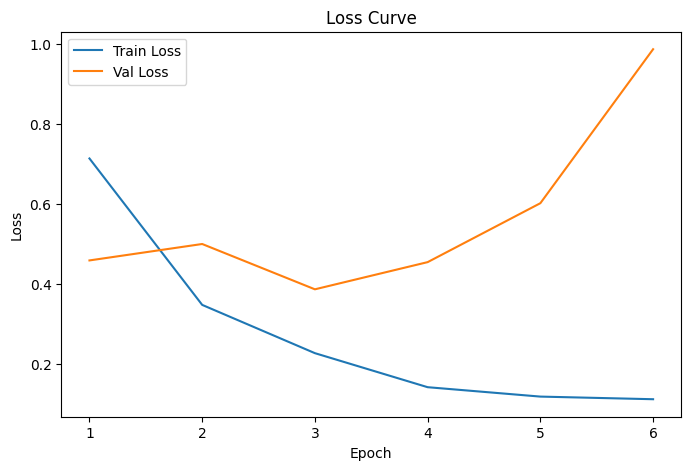

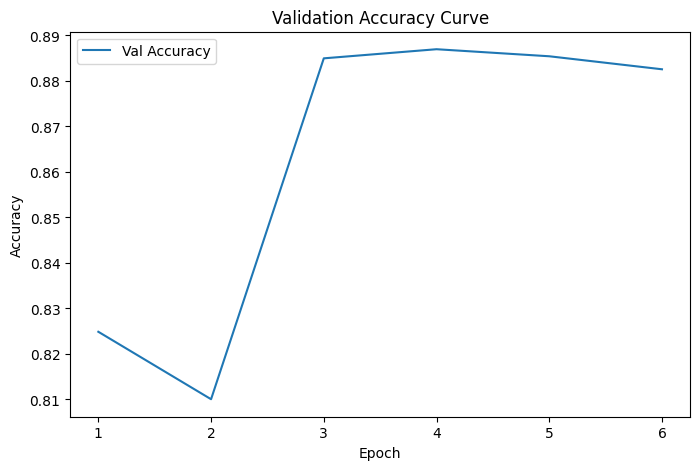

In [19]:
import matplotlib.pyplot as plt

# train_losses, val_losses, val_accuracies phải là list theo epoch
epochs_ran = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs_ran, train_losses, label="Train Loss")
plt.plot(epochs_ran, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs_ran, val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Curve")
plt.legend()
plt.show()


In [20]:
import torch

BEST_PT_PATH = "checkpoints/best_model.pt"  # đổi đúng path bạn lưu

model.load_state_dict(torch.load(BEST_PT_PATH, map_location=device))
model.to(device)
model.eval()

print("Loaded best model from:", BEST_PT_PATH)


Loaded best model from: checkpoints/best_model.pt


In [21]:
from transformers import BertForSequenceClassification

MODEL_DIR = "checkpoints/bert_best"
model = BertForSequenceClassification.from_pretrained(MODEL_DIR).to(device)
model.eval()
print("Loaded HF model from:", MODEL_DIR)


Loaded HF model from: checkpoints/bert_best


## 14. Đánh giá mô hình bằng Classification Report và Confusion Matrix

Sau khi huấn luyện, mô hình được đánh giá chi tiết trên tập validation để hiểu rõ hiệu năng theo từng lớp.

Nội dung đánh giá gồm:
- **Classification Report**: hiển thị các chỉ số `precision`, `recall`, `f1-score` cho từng nhãn  
  - `precision`: mức độ “đúng” trong các dự đoán của một lớp  
  - `recall`: mức độ “bắt được” đúng các mẫu thuộc lớp đó  
  - `f1-score`: cân bằng giữa precision và recall, phù hợp khi dữ liệu có thể không cân bằng
- **Confusion Matrix**: trực quan hóa các trường hợp mô hình dự đoán đúng/sai giữa các lớp  
  - Giúp nhận ra mô hình thường nhầm lớp nào sang lớp nào (ví dụ: nhầm `hate_speech` thành `offensive_language`)

**Kết quả mong đợi:** có cái nhìn toàn diện về hiệu năng mô hình, không chỉ dựa vào accuracy mà còn nhìn rõ điểm mạnh/yếu theo từng nhãn.


                    precision    recall  f1-score   support

       hate_speech     0.3502    0.5315    0.4222       143
offensive_language     0.9520    0.9089    0.9299      1920
           neither     0.8508    0.8774    0.8639       416

          accuracy                         0.8818      2479
         macro avg     0.7177    0.7726    0.7387      2479
      weighted avg     0.9003    0.8818    0.8896      2479



<Figure size 600x600 with 0 Axes>

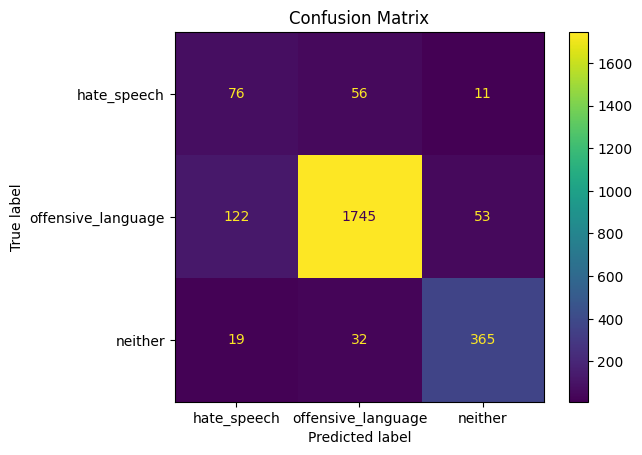

In [22]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# map id -> label (phải đúng với label2id bạn dùng khi train)
id2label = {0: "hate_speech", 1: "offensive_language", 2: "neither"}

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_input_mask
        )
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---- Classification report ----
target_names = [id2label[i] for i in sorted(id2label.keys())]
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

# ---- Confusion matrix ----
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(6, 6))
disp.plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()


In [1]:
import json

path = "Bert_pipeline.ipynb"  # đúng tên file của bạn
with open(path, "r", encoding="utf-8") as f:
    nb = json.load(f)

nb.get("metadata", {}).pop("widgets", None)

for cell in nb.get("cells", []):
    cell.get("metadata", {}).pop("widgets", None)

with open(path, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Done: removed metadata.widgets")


Done: removed metadata.widgets


## 🔚 Kết luận và đánh giá mô hình

Trong thí nghiệm này, mô hình **BERT fine-tuning** được áp dụng cho bài toán phân loại văn bản với ba nhãn: *hate_speech*, *offensive_language* và *neither*. Kết quả đánh giá trên tập kiểm tra cho thấy mô hình đạt hiệu năng tổng thể khá tốt, tuy nhiên vẫn tồn tại những hạn chế rõ rệt ở lớp thiểu số.

### 📊 Tổng quan kết quả
- **Accuracy:** ≈ **88.1%**
- **Weighted F1-score:** ≈ **0.892**
- **Macro F1-score:** ≈ **0.746**

Sự chênh lệch giữa *weighted F1* và *macro F1* cho thấy mô hình chịu ảnh hưởng đáng kể từ sự mất cân bằng dữ liệu và hoạt động tốt hơn trên các lớp chiếm đa số.

### 🔍 Phân tích theo từng lớp
- **offensive_language**
  - Precision và recall cao (≈ 0.96 và ≈ 0.90)
  - Là lớp chiếm đa số nên mô hình học được ranh giới phân loại rõ ràng.
- **neither**
  - Hiệu năng ổn định với F1-score ≈ **0.88**
  - Ít bị nhầm lẫn với hai lớp còn lại.
- **hate_speech**
  - Hiệu năng thấp nhất với F1-score ≈ **0.43**
  - Nhiều mẫu bị nhầm sang *offensive_language*, thể hiện rõ qua Confusion Matrix.
  - Nguyên nhân chính:
    - Số lượng mẫu hạn chế
    - Ranh giới ngữ nghĩa mờ giữa *hate_speech* và *offensive_language*
    - Data augmentation bằng synonym replacement chưa đủ đa dạng về ngữ cảnh

### 🧠 Nhận xét
- Accuracy cao **không phản ánh đầy đủ** chất lượng mô hình cho bài toán nhạy cảm như phát hiện hate speech.
- **Macro F1-score** là chỉ số phù hợp hơn để đánh giá hiệu năng tổng thể giữa các lớp.
- Pipeline đã **tránh được data leakage** do dữ liệu được chia train/test trước khi thực hiện augmentation, đảm bảo tính khách quan của kết quả.

### 🚀 Hướng cải tiến
- Áp dụng **loss function nhạy với lớp thiểu số** (Focal Loss, tuned class weights)
- Sử dụng **context-aware data augmentation** (back-translation, paraphrasing)
- Thử nghiệm các mô hình mạnh hơn như *RoBERTa* hoặc *DeBERTa*
- Thực hiện **error analysis** chi tiết cho các mẫu *hate_speech* bị dự đoán sai

### ✅ Tổng kết
Pipeline được xây dựng đầy đủ từ tiền xử lý, cân bằng dữ liệu, huấn luyện, đến đánh giá mô hình. Mặc dù BERT đạt hiệu năng cao trên các lớp phổ biến, việc cải thiện khả năng nhận diện *hate_speech* vẫn là thách thức chính cần được tập trung trong các nghiên cứu tiếp theo.
